In [1]:
'''
Author: Christopher Mannes

Clustering program to determine a user's home location(s) and work location(s).
'''

'''Import libraries'''
import sys
import string
import datetime
import math as m
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [2]:
'''
Class KMeansObj stores data for a given user and provides a set
of functions for applying kmeans clustering and plotting results.
'''
class KMeansObj():

    def __init__(self, idNumber, numClusters, plotOn):
        self.idNumber = idNumber
        self.k = numClusters
        self.plotOn = plotOn
        
        self.wcss = []
        self.silhouetteScore = []
        
        self.clusterMap = pd.DataFrame()

        self.import_user_data()
        
    '''
    The function imports_user_data reads the specified csv file from the 
    current working directory as Panda DataFrame. The date information
    is used to calculate the day of the week. Then the position in lat.
    and long., the day of the week, the hour of day, and duration are 
    collected into a final table and the rest is dropped. The function
    apply_kmeans_iter is then called.
    '''
    def import_user_data(self):
        userID = "person" + str(self.idNumber) + ".csv"
        self.locHistDF = pd.read_csv(userID, 
                                    sep = ';',
                                    names = ['latitude', 'longitude', 'start_time(YYYYMMddHHmmZ)', 'duration(ms)'])
        self.locHistDF = self.locHistDF.iloc[1:,]

        self.locHistDF['Year'] = pd.DataFrame(self.locHistDF['start_time(YYYYMMddHHmmZ)'].str[0:4])
        self.locHistDF['Month'] = pd.DataFrame(self.locHistDF['start_time(YYYYMMddHHmmZ)'].str[4:6])
        self.locHistDF['Day'] = pd.DataFrame(self.locHistDF['start_time(YYYYMMddHHmmZ)'].str[6:8])
        self.locHistDF['Hour'] = pd.DataFrame(self.locHistDF['start_time(YYYYMMddHHmmZ)'].str[8:10])
        self.locHistDF = self.locHistDF.drop(['start_time(YYYYMMddHHmmZ)'], axis = 1)
        
        self.length = len(self.locHistDF.index)

#         print(self.locHistDF)

        dataArray = self.locHistDF.values.astype(np.float)
        calendarArray = dataArray[:,3:6]
        
        dataArray = np.delete(dataArray, 3, axis = 1)
        dataArray = np.delete(dataArray, 3, axis = 1)
        dataArray = np.delete(dataArray, 3, axis = 1)

        days = []
        calendarArray = calendarArray.astype(np.int)
        for i in range(np.size(calendarArray, 0)):
            day = datetime.date(calendarArray[i,0], calendarArray[i,1], calendarArray[i,2])
            days.append(day.weekday())
        days = np.array(days).reshape((np.size(calendarArray, 0),1))

        self.dataArray = np.hstack(( dataArray, days ))
        
        self.posArray = self.dataArray[:,0:2]

        self.dataArrayNorm = normalize(self.dataArray, norm = 'l2', axis = 0)
#         print(self.posArray[0:5,:])
        
        self.apply_kmeans_iter()
        
    '''
    The function apply_kmeans_iter iteratively applies kmeans and calculates 
    the With Cluster Sum of Square (WCSS) and the Silhouette score to 
    determine the optimal number of clusters.
    '''
    def apply_kmeans_iter(self):
        
        self.silCount = 1
        self.maxSilhouette = 0
        
        for i in range(2, self.k):
            kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=30, random_state=0)
            kmeans.fit(self.posArray)
            self.wcss.append(kmeans.inertia_)
            silScore = silhouette_score(self.posArray, kmeans.labels_)
            
            if silScore > self.maxSilhouette:
                self.maxSilhouette = silScore
                self.silCount += 1
                
            self.silhouetteScore.append(silhouette_score(self.posArray, kmeans.labels_))
        
        if self.plotOn:
            self.plotSilhouetteScore()
            
        self.apply_kmeans(self.silCount)
        
    '''
    The function apply_kmeans applies kmeans once the optimal number
    of clusters is determined.
    '''
    def apply_kmeans(self, optK):
        
        self.kmeans = KMeans(n_clusters=optK, init='k-means++', max_iter=300, n_init=30, random_state=0)
        self.kmeans.fit(self.posArray)
        
        if self.plotOn:
            plt.scatter(self.posArray[:,0], self.posArray[:,1])
            plt.scatter(self.kmeans.cluster_centers_[:, 0], self.kmeans.cluster_centers_[:, 1], s=300, c='red')
            plt.show()
        
    '''
    The function kmeans_reduction applies soft kmeans clustering to determine 
    the confidence that model has that a each data point belongs any particular
    cluster. Therefore, if the model has a low confidence in all clusters, the
    data point can be removed and kmeans can be called again in order to obtain
    a better defined cluster structure. At the end, the function, apply_kmeans is
    called one last time and the function calc_cluster_radii is called.
    '''
    def kmeans_reduction(self):
        
        def soft_clustering_weights(data, cluster_centres, **kwargs):
    
            """
            Function to calculate the weights from soft k-means.

            data: Array of data. shape = N x F, for N data points and F Features
            cluster_centres: Array of cluster centres. shape = Nc x F, for Nc number of clusters. Input kmeans.cluster_centres_ directly.
            param: m - keyword argument, fuzziness of the clustering. Default 2
            """

            # Fuzziness parameter m>=1. Where m=1 => hard segmentation
            m = 2
            if 'm' in kwargs:
                m = kwargs['m']

            Nclusters = cluster_centres.shape[0]
            Ndp = data.shape[0]
            Nfeatures = data.shape[1]

            # Get distances from the cluster centres for each data point and each cluster
            EuclidDist = np.zeros((Ndp, Nclusters))
            for i in range(Nclusters):
                EuclidDist[:,i] = np.sum((data-np.matlib.repmat(cluster_centres[i], Ndp, 1))**2,axis=1)



            # Denominator of the weight from wikipedia:
            invWeight = EuclidDist**(2/(m-1))*np.matlib.repmat(np.sum((1./EuclidDist)**(2/(m-1)),axis=1).reshape(-1,1),1,Nclusters)
            Weight = 1./invWeight

            return Weight
        
        
        weights = soft_clustering_weights(self.posArray, self.kmeans.cluster_centers_)

        weights = np.where(weights > 0.99, 1, 0)

        counter = 0

        for i in range(self.length):
            if np.sum(weights[i,:]) < 1:
                self.posArray = np.delete(self.posArray, counter, 0)
                counter -= 1
            counter += 1

        
        if self.plotOn:
            plt.scatter(self.posArray[:,0], userA.posArray[:,1])
            plt.scatter(self.kmeans.cluster_centers_[:, 0], self.kmeans.cluster_centers_[:, 1], s=300, c='red')
            plt.show()

            
        self.apply_kmeans(self.silCount)
        
        self.clusterMap['data_index'] = range(self.posArray.shape[0])
        self.clusterMap['latitude'] = self.posArray[:,0]
        self.clusterMap['longitude'] = self.posArray[:,1]
        self.clusterMap['cluster'] = self.kmeans.labels_
        
#         print(len(self.clusterMap.index.values))

        self.calc_cluster_radii()
    
    '''
    The function calc_cluster_radii determines the maximum distance of the
    data points in each cluster.
    '''
    def calc_cluster_radii(self):
        
        ''' Function for calculating distance between two latitude and longitude points. '''
        def get_distance(lat1, lon1, lat2, lon2):
            R = 6731000
            distLat = m.radians(lat2 - lat1)
            distLon = m.radians(lon2 - lon1)
            a = (m.sin(distLat/2))**2 + m.cos(m.radians(lat1))*m.cos(m.radians(lat2))*((m.sin(distLon/2))**2)  
            c = m.atan2(m.sqrt(a), m.sqrt(1 - a))
            d = round(R*c, 0)

            return d
        
        self.maxRadiiForClusters = np.zeros((self.kmeans.cluster_centers_.shape[0]))
        
        for i in range(self.kmeans.cluster_centers_.shape[0]):
            maxRad = 0
            lat1 = self.kmeans.cluster_centers_[i,0]
            lon1 = self.kmeans.cluster_centers_[i,1]
            
            clusterNum = self.clusterMap['cluster']==i
            clusterSubDF = self.clusterMap[clusterNum]
            
            for j in range(len(clusterSubDF.index.values)):
                lat2 = clusterSubDF.iloc[j,1]
                lon2 = clusterSubDF.iloc[j,2]
                
                radius = get_distance(lat1, lon1, lat2, lon2)
                
                if radius > maxRad:
                    maxRad = radius
                    
            self.maxRadiiForClusters[i] = maxRad 
                
            
#         print(self.maxRadiiForClusters)
        
        
    def plotSilhouetteScore(self):
        
        plt.plot(range(2,self.k), self.silhouetteScore, '-o')
        plt.title('KMeans Analysis')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Silhouette Score (unitless)')
        plt.show() 
            
    def plotWCSS(self):
        
        plt.plot(range(2,self.k), self.wcss, '-o')
        plt.title('KMeans Analysis')
        plt.xlabel('Number of Clusters')
        plt.ylabel('WCSS (unitless)')
        plt.show() 
        
    def plotPos(self):
        
        plt.plot(self.posArray[:,0], self.posArray[:,1], 'ob')
        plt.title('Latitude and Longitude Position')
        plt.xlabel('Latitudes')
        plt.ylabel('Longitude')
        plt.show() 
        
        

In [3]:
def soft_clustering_weights(data, cluster_centres, **kwargs):
    
    """
    Function to calculate the weights from soft k-means.
    
    data: Array of data. shape = N x F, for N data points and F Features
    cluster_centres: Array of cluster centres. shape = Nc x F, for Nc number of clusters. Input kmeans.cluster_centres_ directly.
    param: m - keyword argument, fuzziness of the clustering. Default 2
    """
    
    # Fuzziness parameter m>=1. Where m=1 => hard segmentation
    m = 2
    if 'm' in kwargs:
        m = kwargs['m']
    
    Nclusters = cluster_centres.shape[0]
    Ndp = data.shape[0]
    Nfeatures = data.shape[1]

    # Get distances from the cluster centres for each data point and each cluster
    EuclidDist = np.zeros((Ndp, Nclusters))
    for i in range(Nclusters):
        EuclidDist[:,i] = np.sum((data-np.matlib.repmat(cluster_centres[i], Ndp, 1))**2,axis=1)
    

    
    # Denominator of the weight from wikipedia:
    invWeight = EuclidDist**(2/(m-1))*np.matlib.repmat(np.sum((1./EuclidDist)**(2/(m-1)),axis=1).reshape(-1,1),1,Nclusters)
    Weight = 1./invWeight
    
    return Weight


''' Function for calculating distance between two latitude and longitude points. '''
def get_distance(lat1, lon1, lat2, lon2):
    R = 6731000
    distLat = m.radians(lat2 - lat1)
    distLon = m.radians(lon2 - lon1)
    a = (m.sin(distLat/2))**2 + m.cos(m.radians(lat1))*m.cos(m.radians(lat2))*((m.sin(distLon/2))**2)  
    c = m.atan2(m.sqrt(a), m.sqrt(1 - a))
    d = round(R*c, 0)

    return d


Hard kmeans applied to to person1.csv iteratively and the corresponding silhouette score is obtained for each iteration as shown in the top graph. Then hard kmeans is applied using the number of clusters with the highest
silhouettte score, which is displaued in the bottom graph.

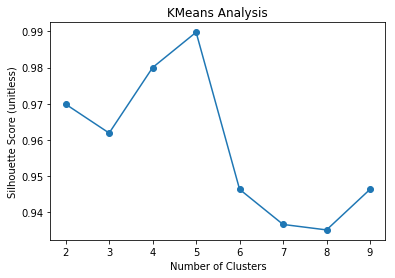

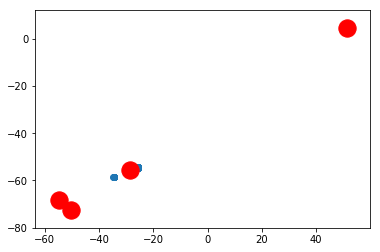

In [4]:
user1 = KMeansObj(1, 10, True)


Hard kmeans applied to to person2.csv iteratively and the corresponding silhouette score is obtained for each iteration as shown in the top graph. Then hard kmeans is applied using the number of clusters with the highest
silhouettte score, which is displaued in the bottom graph.

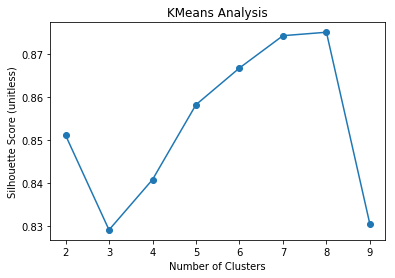

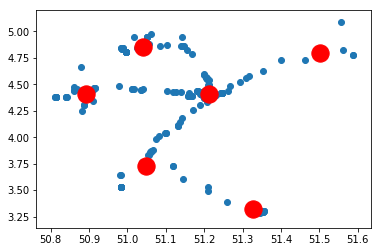

In [5]:
user2 = KMeansObj(2, 10, True)


Hard kmeans applied to to person3.csv iteratively and the corresponding silhouette score is obtained for each iteration as shown in the top graph. Then hard kmeans is applied using the number of clusters with the highest
silhouettte score, which is displaued in the bottom graph.

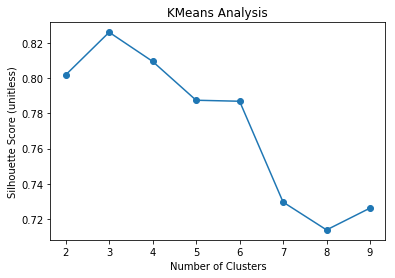

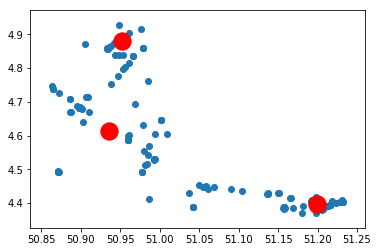

In [6]:
user3 = KMeansObj(3, 10, True)


Soft kmeans clustering is applied and any data point in which the model does not have a confidence of atleast 0.99 in any cluster is remove (upper graph) and kmeans is applied again and the updated cluster centers is obtained (lower graph).

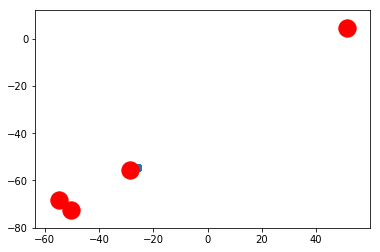

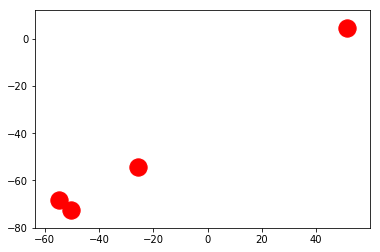

In [7]:
weights1 = soft_clustering_weights(user1.posArray, user1.kmeans.cluster_centers_)

weights1 = np.where(weights1 > 0.99, 1, 0)

counter = 0

for i in range(user1.length):
    if np.sum(weights1[i,:]) < 1:
        user1.posArray = np.delete(user1.posArray, counter, 0)
        counter -= 1
    counter += 1
    
    
plt.scatter(user1.posArray[:,0], user1.posArray[:,1])
plt.scatter(user1.kmeans.cluster_centers_[:, 0], user1.kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

user1.apply_kmeans(user1.silCount)


Soft kmeans clustering is applied and any data point in which the model does not have a confidence of atleast 0.99 in any cluster is remove (upper graph) and kmeans is applied again and the updated cluster centers is obtained (lower graph).

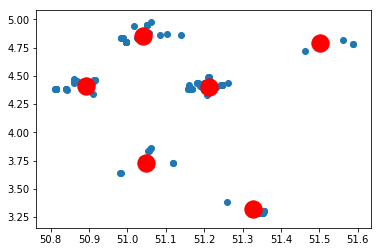

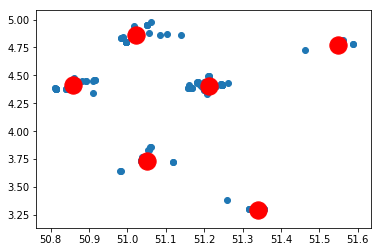

In [8]:
weights2 = soft_clustering_weights(user2.posArray, user2.kmeans.cluster_centers_)

weights2 = np.where(weights2 > 0.99, 1, 0)

counter = 0

for i in range(user2.length):
    if np.sum(weights2[i,:]) < 1:
        user2.posArray = np.delete(user2.posArray, counter, 0)
        counter -= 1
    counter += 1
    
    
plt.scatter(user2.posArray[:,0], user2.posArray[:,1])
plt.scatter(user2.kmeans.cluster_centers_[:, 0], user2.kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

user2.apply_kmeans(user2.silCount)



Soft kmeans clustering is applied and any data point in which the model does not have a confidence of atleast 0.99 in any cluster is remove (upper graph) and kmeans is applied again and the updated cluster centers is obtained (lower graph).

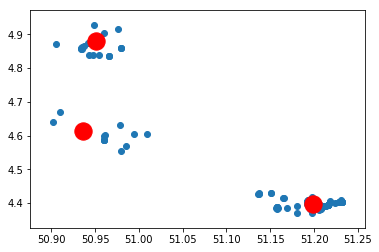

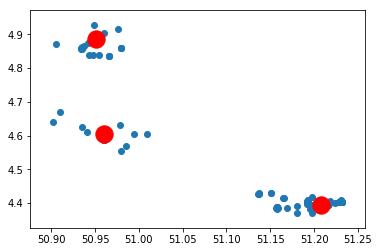

In [9]:
weights3 = soft_clustering_weights(user3.posArray, user3.kmeans.cluster_centers_)

weights3 = np.where(weights3 > 0.99, 1, 0)

counter = 0

for i in range(user3.length):
    if np.sum(weights3[i,:]) < 1:
        user3.posArray = np.delete(user3.posArray, counter, 0)
        counter -= 1
    counter += 1
    
    
plt.scatter(user3.posArray[:,0], user3.posArray[:,1])
plt.scatter(user3.kmeans.cluster_centers_[:, 0], user3.kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

user3.apply_kmeans(user3.silCount)


Selected cluster centers are plotted to confirm the results obtained in cell[13] for person1.csv

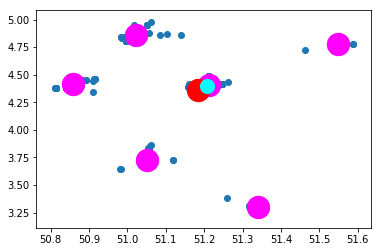

In [10]:
plt.scatter(user2.posArray[:,0], user2.posArray[:,1])
plt.scatter(user2.kmeans.cluster_centers_[:, 0], user2.kmeans.cluster_centers_[:, 1], s=500, c='magenta')
plt.scatter(user1.kmeans.cluster_centers_[0, 0], user1.kmeans.cluster_centers_[0, 1], s=500, c='red')
plt.scatter(user3.kmeans.cluster_centers_[0, 0], user3.kmeans.cluster_centers_[0, 1], s=200, c='cyan')
plt.show()


Selected cluster centers are plotted to confirm the results obtained in cell[13] for person 1.csv.

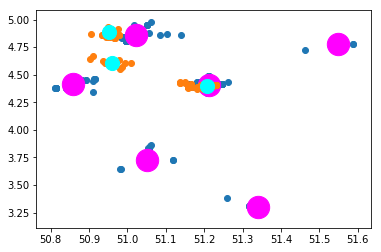

In [11]:
plt.scatter(user2.posArray[:,0], user2.posArray[:,1])
plt.scatter(user2.kmeans.cluster_centers_[:, 0], user2.kmeans.cluster_centers_[:, 1], s=500, c='magenta')
plt.scatter(user3.posArray[:,0], user3.posArray[:,1])
plt.scatter(user3.kmeans.cluster_centers_[:, 0], user3.kmeans.cluster_centers_[:, 1], s=200, c='cyan')
plt.show()


A list of KMeanObj is obtained for person2.csv and person3.csv, which form the database of the system. 

In [12]:
kmeansObjList = []

for i in range(2,4):
    k = KMeansObj(i, 10, False)
    k.kmeans_reduction()
    kmeansObjList.append(k)



Then the distance between the cluster centers is compared with the cluster centers in the databases, if the calculated distance is less than the maximum radius of the cluster in the dataset under investigation, then the location is assigned a work location label, else it is assigned a home location label.

In [13]:
user = KMeansObj(1, 10, False)
user.kmeans_reduction()

for i in range(user.kmeans.cluster_centers_.shape[0]):
    
    homeFlag = True
    
    lat1 = user.kmeans.cluster_centers_[i,0]
    lon1 = user.kmeans.cluster_centers_[i,1]
    
    for j in kmeansObjList:
        
        for k in range(j.kmeans.cluster_centers_.shape[0]):
            
            lat2 = j.kmeans.cluster_centers_[k,0]
            lon2 = j.kmeans.cluster_centers_[k,1]
            
            radius = get_distance(lat1, lon1, lat2, lon2)
            
            if radius < user.maxRadiiForClusters[i]:
                print("Cluster " + str(i) + " located at (" + str(lat1) + "," + str(lon1) + ") is a likely work location. \n")
                homeFlag = False
                break
             
    if homeFlag:
        print("Cluster " + str(i) + " located at (" + str(lat1) + "," + str(lon1) + ") is a likely home location. \n")



Cluster 0 located at (51.18464769791666,4.356714334114589) is a likely work location. 

Cluster 0 located at (51.18464769791666,4.356714334114589) is a likely work location. 

Cluster 1 located at (-50.24192556,-72.3919587733333) is a likely home location. 

Cluster 2 located at (-25.651647227272733,-54.49754777272727) is a likely home location. 

Cluster 3 located at (-54.814324362069,-68.32657453448276) is a likely home location. 

